## Code to recreate plots in figure S3

In [1]:
# Import Libraries
from caveclient import CAVEclient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

client = CAVEclient()
datastack_name = 'fanc_production_mar2021'
client = CAVEclient(datastack_name)

In [5]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    dend_dict = dendrogram(linkage_matrix, **kwargs)
    
    # sorted order of indices found through clustering
    clustered_order = dend_dict['ivl']
    plt.close()
    
    return clustered_order

In [6]:
# Specify the root_ids of the sensory neurons that we care about, put them into a list
FeCO_df= client.materialize.query_table('feco_axons_v0')
FeCO_df = FeCO_df[FeCO_df['classification_system'].str.contains('T1L')]
FeCO_df = FeCO_df.replace(to_replace='maybeclub', value='club')
FeCO_df = FeCO_df.replace(to_replace='club_asc', value='club')

hook_ids = FeCO_df[FeCO_df['cell_type'].str.contains('hook')]['pt_root_id'].to_list()
hook_types = FeCO_df[FeCO_df['cell_type'].str.contains('hook')]['cell_type'].to_list()

claw_ids = FeCO_df[FeCO_df['cell_type'].str.contains('claw')]['pt_root_id'].to_list()
claw_types = FeCO_df[FeCO_df['cell_type'].str.contains('claw')]['cell_type'].to_list()

club_ids = FeCO_df[FeCO_df['cell_type'].str.contains('club')]['pt_root_id'].to_list()
club_types = FeCO_df[FeCO_df['cell_type'].str.contains('club')]['cell_type'].to_list()

allFeCO_ids = claw_ids+hook_ids+club_ids
allFeCO_types = claw_types+hook_types+club_types
FeCO_dict = dict(zip(allFeCO_ids,allFeCO_types))

C:\Users\swetarr\anaconda3\envs\connectomics\lib\site-packages\pandas\core\missing.py:95: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  new_mask = arr == x


In [7]:
#find all the postsynaptic partners that receive more than 3 synapses from an FeCO neuron. This will give us a dataframe with a list of downstream neurons and how many synapses they receive from one of the 
# FeCO neurons. It is possible they receive more synapses total since we got rid of duplicate entries. We also don't 
# know who the upstream partner is, but the assumption is that we can deal with figuring that out when doing analysis.

syn_threshold = 3; 

outputs = client.materialize.synapse_query(pre_ids = allFeCO_ids)
syn_per_output = outputs.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
syn_per_output = syn_per_output[[ "pre_pt_root_id", "post_pt_root_id", "number_of_synapses"]][syn_per_output['number_of_synapses'] > syn_threshold]

inputs = client.materialize.synapse_query(post_ids = allFeCO_ids)
syn_per_input = inputs.groupby(['pre_pt_root_id','post_pt_root_id'])['pre_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
syn_per_input = syn_per_input[[ "pre_pt_root_id", "post_pt_root_id", "number_of_synapses"]][syn_per_input['number_of_synapses'] >= syn_threshold]

all_partners = syn_per_output.drop_duplicates(subset = "post_pt_root_id")['post_pt_root_id'].to_list() + syn_per_input.drop_duplicates(subset = "pre_pt_root_id")['pre_pt_root_id'].to_list()

In [8]:
#cluster the FeCO neurons (within each subtype) based on cosine similarity. 
# Will be continuing to use this order throughout the code below

# Further filter the downstream targets by using 40 output synapses as a threshold 
# (gets rid of fragments, but keeps large things that may be missing somas)

synapse_out_counts = client.materialize.query_view('synapse_out_counts', filter_in_dict={'root_id': all_partners})
lotsa_outputs_ids = synapse_out_counts.query('n_output>40')['root_id'].to_list()

notsmall_outputs = syn_per_output[syn_per_output['post_pt_root_id'].isin(lotsa_outputs_ids)]
notsmall_outputs_ids = np.unique(notsmall_outputs['post_pt_root_id'].to_list())

notsmall_inputs = syn_per_input[syn_per_input['pre_pt_root_id'].isin(lotsa_outputs_ids)]
notsmall_inputs_ids = np.unique(notsmall_inputs['post_pt_root_id'].to_list())

#compute similarity matrix of FeCO neurons based on their outputs, not small partners that receive 4+ synapses.
#separate similarity matrices for each FeCO subtype (club, claw, hook, maybeclub)

#hook
hookds_connectivity_matrix = np.zeros((len(notsmall_outputs_ids), len(hook_ids)))

index1 = 0
index2 = 0
for j, out_id in enumerate(notsmall_outputs_ids):
    for i, FeCO_id in enumerate(hook_ids):
        index1 += 1
        try:
            hookds_connectivity_matrix[j,i] = notsmall_outputs.number_of_synapses[(notsmall_outputs['post_pt_root_id'] == out_id) & (notsmall_outputs['pre_pt_root_id'] == FeCO_id)].values[0]
        except IndexError:
            index2 += 1
            
#claw
clawds_connectivity_matrix = np.zeros((len(notsmall_outputs_ids), len(claw_ids)))

index1 = 0
index2 = 0
for j, out_id in enumerate(notsmall_outputs_ids):
    for i, FeCO_id in enumerate(claw_ids):
        index1 += 1
        try:
            clawds_connectivity_matrix[j,i] = notsmall_outputs.number_of_synapses[(notsmall_outputs['post_pt_root_id'] == out_id) & (notsmall_outputs['pre_pt_root_id'] == FeCO_id)].values[0]
        except IndexError:
            index2 += 1
            
#club
clubds_connectivity_matrix = np.zeros((len(notsmall_outputs_ids), len(club_ids)))

index1 = 0
index2 = 0
for j, out_id in enumerate(notsmall_outputs_ids):
    for i, FeCO_id in enumerate(club_ids):
        index1 += 1
        try:
            clubds_connectivity_matrix[j,i] = notsmall_outputs.number_of_synapses[(notsmall_outputs['post_pt_root_id'] == out_id) & (notsmall_outputs['pre_pt_root_id'] == FeCO_id)].values[0]
        except IndexError:
            index2 += 1
            
#also the similarity matrix all of the FeCO neurons
allds_connectivity_matrix = np.zeros((len(notsmall_outputs_ids), len(allFeCO_ids)))

index1 = 0
index2 = 0
for j, out_id in enumerate(notsmall_outputs_ids):
    for i, FeCO_id in enumerate(allFeCO_ids):
        index1 += 1
        try:
            allds_connectivity_matrix[j,i] = notsmall_outputs.number_of_synapses[(notsmall_outputs['post_pt_root_id'] == out_id) & (notsmall_outputs['pre_pt_root_id'] == FeCO_id)].values[0]
        except IndexError:
            index2 += 1
            
if index1-index2 == len(notsmall_outputs):
    print('huzzah!')


huzzah!


In [9]:
# compute similarity, perform clustering on each subtype matrix. We'll use the ordering of the rows to reorder the all FeCO matrix

#hook
# Cluster (reorder) downstream partners according to the cosine similarity of their connectivity with FeCO neurons
hookds_similarity_matrix = cosine_similarity(hookds_connectivity_matrix)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(hookds_similarity_matrix) # Setting distance_threshold=0 ensures we compute the full tree.
h_order_rows = plot_dendrogram(model, truncate_mode="level", p=hookds_connectivity_matrix.shape[0]) # p truncate mode; use number of upstream partners
h_order_rows = np.array(h_order_rows).astype(int) # Convert strings to integers
hookds_connectivity_matrix_clustered_rows = hookds_connectivity_matrix[h_order_rows, :]
hook_dsids_clustered = np.array(notsmall_outputs_ids)[h_order_rows].tolist()

# Additionally cluster (reorder) FeCO neurons according to the cosine similarity of their connectivity with downstream partners
hookds_similarity_matrix = cosine_similarity(np.transpose(hookds_connectivity_matrix))
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(hookds_similarity_matrix)
h_order_cols = plot_dendrogram(model, truncate_mode="level", p=hookds_connectivity_matrix.shape[1]) # p truncate mode; use number of FeCO neurons 
h_order_cols = np.array(h_order_cols).astype(int)
hookds_connectivity_matrix_clustered_rows_cols = hookds_connectivity_matrix_clustered_rows[:, h_order_cols]
hookids_clustered = np.array(hook_ids)[h_order_cols].tolist()
hooktypes_clustered = np.array(hook_types)[h_order_cols].tolist()

hookds_similarity_matrix = hookds_similarity_matrix[h_order_cols, :]
hookds_similarity_matrix = hookds_similarity_matrix[:, h_order_cols]


#claw
# Cluster (reorder) downstream partners according to the cosine similarity of their connectivity with FeCO neurons
clawds_similarity_matrix = cosine_similarity(clawds_connectivity_matrix)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(clawds_similarity_matrix) # Setting distance_threshold=0 ensures we compute the full tree.
cw_order_rows = plot_dendrogram(model, truncate_mode="level", p=clawds_connectivity_matrix.shape[0]) # p truncate mode; use number of upstream partners
cw_order_rows = np.array(cw_order_rows).astype(int) # Convert strings to integers
clawds_connectivity_matrix_clustered_rows = clawds_connectivity_matrix[cw_order_rows, :]
claw_dsids_clustered = np.array(notsmall_outputs_ids)[cw_order_rows].tolist()

# Additionally cluster (reorder) FeCO neurons according to the cosine similarity of their connectivity with downstream partners
clawds_similarity_matrix = cosine_similarity(np.transpose(clawds_connectivity_matrix))
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(clawds_similarity_matrix)
cw_order_cols = plot_dendrogram(model, truncate_mode="level", p=clawds_connectivity_matrix.shape[1]) # p truncate mode; use number of FeCO neurons 
cw_order_cols = np.array(cw_order_cols).astype(int)
clawds_connectivity_matrix_clustered_rows_cols = clawds_connectivity_matrix_clustered_rows[:, cw_order_cols]
clawids_clustered = np.array(claw_ids)[cw_order_cols].tolist()
clawtypes_clustered = np.array(claw_types)[cw_order_cols].tolist()

clawds_similarity_matrix = clawds_similarity_matrix[cw_order_cols, :]
clawds_similarity_matrix = clawds_similarity_matrix[:, cw_order_cols]

#club
# Cluster (reorder) downstream partners according to the cosine similarity of their connectivity with FeCO neurons
clubds_similarity_matrix = cosine_similarity(clubds_connectivity_matrix)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(clubds_similarity_matrix) # Setting distance_threshold=0 ensures we compute the full tree.
cb_order_rows = plot_dendrogram(model, truncate_mode="level", p=clubds_connectivity_matrix.shape[0]) # p truncate mode; use number of upstream partners
cb_order_rows = np.array(cb_order_rows).astype(int) # Convert strings to integers
clubds_connectivity_matrix_clustered_rows = clubds_connectivity_matrix[cb_order_rows, :]
club_dsids_clustered = np.array(notsmall_outputs_ids)[cb_order_rows].tolist()

# Additionally cluster (reorder) FeCO neurons according to the cosine similarity of their connectivity with downstream partners
clubds_similarity_matrix = cosine_similarity(np.transpose(clubds_connectivity_matrix))
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(clubds_similarity_matrix)
cb_order_cols = plot_dendrogram(model, truncate_mode="level", p=clubds_connectivity_matrix.shape[1]) # p truncate mode; use number of FeCO neurons 
cb_order_cols = np.array(cb_order_cols).astype(int)
clubds_connectivity_matrix_clustered_rows_cols = clubds_connectivity_matrix_clustered_rows[:, cb_order_cols]
clubids_clustered = np.array(club_ids)[cb_order_cols].tolist()
clubtypes_clustered = np.array(club_types)[cb_order_cols].tolist()

clubds_similarity_matrix = clubds_similarity_matrix[cb_order_cols, :]
clubds_similarity_matrix = clubds_similarity_matrix[:, cb_order_cols]

#########
#order of FeCO neurons based on clustering within subtypes
all_order_cols = np.concatenate([cw_order_cols, h_order_cols+len(claw_ids), cb_order_cols+len(hook_ids)+len(claw_ids)]) 

allFeCO_ids_clustered = np.array(allFeCO_ids)[all_order_cols].tolist()
allFeCO_types_clustered = np.array(allFeCO_types)[all_order_cols].tolist()

## use downstream tables to pull out information about types of neurons

In [10]:
Ach_HL = ['1A', '3A', '4B', '7B', '8B', '10B', '11A', '12A', '17A', '18B', '19B', 
          '20A', '22A', '23B', 'sensory', 'hook', 'hair_plate', 'claw', 'club']

Glu_HL = ['2A', '8A', '9B', '14A', '15B', '16B', '21A', '24B', 'MN']

GABA_HL = ['0A/0B', '1B', '3B', '5B', '9A','12B', '6A', '6B', '11B', '13A', 
           '13B', '19A']

U_HL = ['16A', 'unknown']
frag = ['fragment']

NT_order = [Ach_HL, GABA_HL, Glu_HL, U_HL]
HL_order = Ach_HL+GABA_HL+Glu_HL+U_HL

In [11]:
#Load in the classification data for the partners of FeCO neurons!

#outputs
downstream_AT= client.materialize.query_table('downstream_feco_axons_v1')

# add in NT values for motor and sensory neurons, which are not in either table yet
def fill_NT(row):
    if row['cell_type'] in Glu_HL:
        return 'Glu'
    elif row['cell_type'] in Ach_HL:
        return 'Ach'
    elif row['cell_type'] in GABA_HL:
        return 'GABA'
    elif row['cell_type'] in U_HL:
        return 'unknown'
    elif row['cell_type'] == 'fragment':
        return 'fragment'
    else:
        return 'unknown'
    
    
downstream_AT['Neurotransmitter'] = downstream_AT.apply(lambda row : fill_NT(row), axis=1) 


# inputs
upstream_AT= client.materialize.query_table('upstream_feco_axons')
upstream_AT['Neurotransmitter'] = upstream_AT.apply(lambda row : fill_NT(row), axis=1) 

In [12]:
HL_categories = ['0A/0B', '1A', '1B', '2A', '3A', '3B', '4B', '5B', '6A', '6B', '7B','8A', '8B', '9A', '9B', '10B', '11A', 
                 '11B', '12A', '12B', '13A', '13B', '14A', '15B', '16A', '16B', '17A', '18B', '19A', '19B', '20A', '21A', 
                 '21B', '22A', '23B', '24B', 'unknown']

NT_categories = ['Ach', 'GABA', 'Glu', 'unknown', 'fragment']

classification_categories = ['ascending', 'intersegmental', 'decending', 'local', 'MN', 'sensory', 'unknown', 'fragment']

In [13]:
#loop through each sensory neuron (in order suggested by cosine similarity) and consolidate information into a few different lists:
#includes both numbers of neurons (counts), numbers of synapses (syns), and percent of synapses (psyns)

#start with outputs
outputinfo = pd.DataFrame()

FeCOids = []
FeCOtypes = []
FeCOoutsyns = []
FeCOinsyns = []

all_output_ids = []
all_output_HLcounts = []
all_output_NTcounts = []
all_output_classcounts = []
all_output_HLsyns = []
all_output_NTsyns = []
all_output_classsyns = []
all_output_HLpsyns = []
all_output_NTpsyns = []
all_output_classpsyns = []

for i, segid in enumerate(allFeCO_ids_clustered):
    FeCOids.append(segid)
    FeCOtypes.append(allFeCO_types_clustered[i])
    
    
    ############## working on outputs first ##################
    #find segids of output partners    
    output_ids = syn_per_output.loc[syn_per_output['pre_pt_root_id']==segid].post_pt_root_id.tolist()
    syn_per_partner = syn_per_output.loc[syn_per_output['pre_pt_root_id']==segid].number_of_synapses.tolist()
    total_outsyns = syn_per_output.loc[syn_per_output['pre_pt_root_id']==segid].number_of_synapses.sum()
    
    FeCOoutsyns.append(total_outsyns)
    
    syn_per_partner = dict(zip(output_ids, syn_per_partner)) #create dictionary with the output id and the number of synapses
    all_output_ids.append(syn_per_partner)    
    
    #classify information about those partners, and also count how many we don't know anything about
    types = (downstream_AT[downstream_AT['pt_root_id'].isin(output_ids)]['classification_system'].tolist())
    HLs = (downstream_AT[downstream_AT['pt_root_id'].isin(output_ids)]['cell_type'].tolist())
    NTs = (downstream_AT[downstream_AT['pt_root_id'].isin(output_ids)]['Neurotransmitter'].tolist())
    this_subset = downstream_AT[downstream_AT['pt_root_id'].isin(output_ids)]
    
    #number of partner ids that are not in the detailed table:
    n_unproofread = (len(list(set(output_ids)-set(downstream_AT.pt_root_id))))
    unproofed_syn = sum(syn_per_partner[item] for item in list(set(output_ids)-set(downstream_AT.pt_root_id)))
    
    #number of neurons and number of synapses in each HL
    HL_counts = [0] *(len(HL_categories)+1)
    HL_counts_syn = [0] *(len(HL_categories)+1)
    HL_counts_psyn = [0] *(len(HL_categories)+1)
    
    
    for j, hl in enumerate(HL_categories):
        HL_counts[j] = HLs.count(hl)
        HL_counts_syn[j] = sum(syn_per_partner[item] for item in this_subset[this_subset['cell_type'].isin([hl])]['pt_root_id'].tolist())
        HL_counts_psyn[j] = sum(syn_per_partner[item] for item in this_subset[this_subset['cell_type'].isin([hl])]['pt_root_id'].tolist())/total_outsyns
        
    HL_counts[-1] = n_unproofread
    HL_counts_syn[-1] = unproofed_syn
    HL_counts_psyn[-1] = unproofed_syn/total_outsyns
    
    #number of neurons and number of synapses with each NT
    NT_counts = [0] *(len(NT_categories)+1)
    NT_counts_syn = [0] *(len(NT_categories)+1)
    NT_counts_psyn = [0] *(len(NT_categories)+1)
        
    for j, nt in enumerate(NT_categories):
        NT_counts[j] = NTs.count(nt)
        NT_counts_syn[j] = sum(syn_per_partner[item] for item in this_subset[this_subset['Neurotransmitter'].isin([nt])]['pt_root_id'].tolist())
        NT_counts_psyn[j] = sum(syn_per_partner[item] for item in this_subset[this_subset['Neurotransmitter'].isin([nt])]['pt_root_id'].tolist())/total_outsyns

    NT_counts[-1] = n_unproofread
    NT_counts_syn[-1] = unproofed_syn
    NT_counts_psyn[-1] = unproofed_syn/total_outsyns
    
    #number of neurons and number of synapses in each class
    class_counts = [0] *(len(classification_categories)+1)
    class_counts_syn = [0] *(len(classification_categories)+1)
    class_counts_psyn = [0] *(len(classification_categories)+1)
    
    for j, ct in enumerate(classification_categories):
        class_counts[j] = ' '.join(types).count(ct)
        class_counts_syn[j] = sum(syn_per_partner[item] for item in this_subset[this_subset['classification_system'].str.contains(ct)]['pt_root_id'].tolist())
        class_counts_psyn[j] = sum(syn_per_partner[item] for item in this_subset[this_subset['classification_system'].str.contains(ct)]['pt_root_id'].tolist())/total_outsyns
    
    class_counts[-1] = n_unproofread
    class_counts_syn[-1] = unproofed_syn
    class_counts_psyn[-1] = unproofed_syn/total_outsyns
    
    all_output_HLcounts.append(HL_counts)
    all_output_NTcounts.append(NT_counts)
    all_output_classcounts.append(class_counts)
    
    all_output_HLsyns.append(HL_counts_syn)
    all_output_NTsyns.append(NT_counts_syn)
    all_output_classsyns.append(class_counts_syn)
    
    all_output_HLpsyns.append(HL_counts_psyn)
    all_output_NTpsyns.append(NT_counts_psyn)
    all_output_classpsyns.append(class_counts_psyn)
    
    
outputinfo['FeCO_id'] = FeCOids
outputinfo['FeCO_type'] = FeCOtypes
outputinfo['partner_ids'] = all_output_ids
outputinfo['HL_counts'] = all_output_HLcounts
outputinfo['NT_counts'] = all_output_NTcounts
outputinfo['class_counts'] = all_output_classcounts
outputinfo['HL_syns'] = all_output_HLsyns
outputinfo['NT_syns'] = all_output_NTsyns
outputinfo['class_syns'] = all_output_classsyns
outputinfo['HL_psyns'] = all_output_HLpsyns
outputinfo['NT_psyns'] = all_output_NTpsyns
outputinfo['class_psyns'] = all_output_classpsyns


In [14]:
#inputs
inputinfo = pd.DataFrame()

FeCOids = []
FeCOtypes = []
FeCOoutsyns = []
FeCOinsyns = []

all_input_ids = []
all_input_HLcounts = []
all_input_NTcounts = []
all_input_classcounts = []
all_input_HLsyns = []
all_input_NTsyns = []
all_input_classsyns = []
all_input_HLpsyns = []
all_input_NTpsyns = []
all_input_classpsyns = []

for i, segid in enumerate(allFeCO_ids_clustered):
    FeCOids.append(segid)
    FeCOtypes.append(allFeCO_types_clustered[i])
    
    #find segids of input partners    
    input_ids = syn_per_input.loc[syn_per_input['post_pt_root_id']==segid].pre_pt_root_id.tolist()
    syn_per_partner = syn_per_input.loc[syn_per_input['post_pt_root_id']==segid].number_of_synapses.tolist()
    total_insyns = syn_per_input.loc[syn_per_input['post_pt_root_id']==segid].number_of_synapses.sum()
    
    FeCOinsyns.append(total_insyns)
    
    syn_per_partner = dict(zip(input_ids, syn_per_partner)) #create dictionary with the input id and the number of synapses
    all_input_ids.append(syn_per_partner)    
    
    #classify information about those partners, and also count how many we don't know anything about
    types = (upstream_AT[upstream_AT['pt_root_id'].isin(input_ids)]['classification_system'].tolist())
    HLs = (upstream_AT[upstream_AT['pt_root_id'].isin(input_ids)]['cell_type'].tolist())
    NTs = (upstream_AT[upstream_AT['pt_root_id'].isin(input_ids)]['Neurotransmitter'].tolist())
    this_subset = upstream_AT[upstream_AT['pt_root_id'].isin(input_ids)]
    
    #number of partner ids that are not in the detailed table:
    n_unproofread = (len(list(set(input_ids)-set(upstream_AT.pt_root_id))))
    unproofed_syn = sum(syn_per_partner[item] for item in list(set(input_ids)-set(upstream_AT.pt_root_id)))
    
    #number of neurons and number of synapses in each HL
    HL_counts = [0] *(len(HL_categories)+1)
    HL_counts_syn = [0] *(len(HL_categories)+1)
    HL_counts_psyn = [0] *(len(HL_categories)+1)
    
    
    for j, hl in enumerate(HL_categories):
        HL_counts[j] = HLs.count(hl)
        HL_counts_syn[j] = sum(syn_per_partner[item] for item in this_subset[this_subset['cell_type'].isin([hl])]['pt_root_id'].tolist())
        HL_counts_psyn[j] = sum(syn_per_partner[item] for item in this_subset[this_subset['cell_type'].isin([hl])]['pt_root_id'].tolist())/total_insyns
        
    HL_counts[-1] = n_unproofread
    HL_counts_syn[-1] = unproofed_syn
    HL_counts_psyn[-1] = unproofed_syn/total_insyns
    
    #number of neurons and number of synapses with each NT
    NT_counts = [0] *(len(NT_categories)+1)
    NT_counts_syn = [0] *(len(NT_categories)+1)
    NT_counts_psyn = [0] *(len(NT_categories)+1)
        
    for j, nt in enumerate(NT_categories):
        NT_counts[j] = NTs.count(nt)
        NT_counts_syn[j] = sum(syn_per_partner[item] for item in this_subset[this_subset['Neurotransmitter'].isin([nt])]['pt_root_id'].tolist())
        NT_counts_psyn[j] = sum(syn_per_partner[item] for item in this_subset[this_subset['Neurotransmitter'].isin([nt])]['pt_root_id'].tolist())/total_insyns

    NT_counts[-1] = n_unproofread
    NT_counts_syn[-1] = unproofed_syn
    NT_counts_psyn[-1] = unproofed_syn/total_insyns
    
    #number of neurons and number of synapses in each class
    class_counts = [0] *(len(classification_categories)+1)
    class_counts_syn = [0] *(len(classification_categories)+1)
    class_counts_psyn = [0] *(len(classification_categories)+1)
    
    for j, ct in enumerate(classification_categories):
        class_counts[j] = ' '.join(types).count(ct)
        class_counts_syn[j] = sum(syn_per_partner[item] for item in this_subset[this_subset['classification_system'].str.contains(ct)]['pt_root_id'].tolist())
        class_counts_psyn[j] = sum(syn_per_partner[item] for item in this_subset[this_subset['classification_system'].str.contains(ct)]['pt_root_id'].tolist())/total_insyns
    
    class_counts[-1] = n_unproofread
    class_counts_syn[-1] = unproofed_syn
    class_counts_psyn[-1] = unproofed_syn/total_insyns
    
    all_input_HLcounts.append(HL_counts)
    all_input_NTcounts.append(NT_counts)
    all_input_classcounts.append(class_counts)
    
    all_input_HLsyns.append(HL_counts_syn)
    all_input_NTsyns.append(NT_counts_syn)
    all_input_classsyns.append(class_counts_syn)
    
    all_input_HLpsyns.append(HL_counts_psyn)
    all_input_NTpsyns.append(NT_counts_psyn)
    all_input_classpsyns.append(class_counts_psyn)
    
    
inputinfo['FeCO_id'] = FeCOids
inputinfo['FeCO_type'] = FeCOtypes
inputinfo['partner_ids'] = all_input_ids
inputinfo['HL_counts'] = all_input_HLcounts
inputinfo['NT_counts'] = all_input_NTcounts
inputinfo['class_counts'] = all_input_classcounts
inputinfo['HL_syns'] = all_input_HLsyns
inputinfo['NT_syns'] = all_input_NTsyns
inputinfo['class_syns'] = all_input_classsyns
inputinfo['HL_psyns'] = all_input_HLpsyns
inputinfo['NT_psyns'] = all_input_NTpsyns
inputinfo['class_psyns'] = all_input_classpsyns


C:\Users\swetarr\AppData\Local\Temp\ipykernel_20160\1016745639.py:53: RuntimeWarning: invalid value encountered in longlong_scalars
  HL_counts_psyn[j] = sum(syn_per_partner[item] for item in this_subset[this_subset['cell_type'].isin([hl])]['pt_root_id'].tolist())/total_insyns
C:\Users\swetarr\AppData\Local\Temp\ipykernel_20160\1016745639.py:57: RuntimeWarning: invalid value encountered in longlong_scalars
  HL_counts_psyn[-1] = unproofed_syn/total_insyns
C:\Users\swetarr\AppData\Local\Temp\ipykernel_20160\1016745639.py:67: RuntimeWarning: invalid value encountered in longlong_scalars
  NT_counts_psyn[j] = sum(syn_per_partner[item] for item in this_subset[this_subset['Neurotransmitter'].isin([nt])]['pt_root_id'].tolist())/total_insyns
C:\Users\swetarr\AppData\Local\Temp\ipykernel_20160\1016745639.py:71: RuntimeWarning: invalid value encountered in longlong_scalars
  NT_counts_psyn[-1] = unproofed_syn/total_insyns
C:\Users\swetarr\AppData\Local\Temp\ipykernel_20160\1016745639.py:81: Run

In [15]:
#outputs
NT_dicts = [{}, {}, {}, {}]
all_outputids = []
all_output_mx = []
all_NTid_counts = []
all_HLid_counts = []
all_output_mx_collapsed = []

for j in range(len(NT_order)):
    segids = []
    NTidcounter = 0
    for i, hl in enumerate(NT_order[j]):
        theseids = downstream_AT[downstream_AT['cell_type'] == hl].pt_root_id.tolist()
        
        # create connectivity matrix for each HL
        this_output_mx = np.zeros((len(theseids), len(allFeCO_ids_clustered)))
        index = 0
        NTidcounter+=len(theseids)
        for x, partner_id in enumerate(theseids):
            for y, FeCO_id in enumerate(allFeCO_ids_clustered):
                try:
                    this_output_mx[x,y] = syn_per_output.number_of_synapses[(syn_per_output['post_pt_root_id'] == partner_id) & (syn_per_output['pre_pt_root_id'] == FeCO_id)].values[0]
                except IndexError:
                    index += 1
                    
        #create connectivity matrix where you collapse together all the individuals of an HL
        this_output_mx_collapsed = np.sum(this_output_mx, axis=0)
                    
        #Cluster (reorder) downstream partners within HL matrix according to cosine similarity of connx with FeCO
        if len(theseids)>1:
            similarity_matrix = cosine_similarity(this_output_mx)
            model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(similarity_matrix) # Setting distance_threshold=0 ensures we compute the full tree.
            thisoutputmx_order_rows = plot_dendrogram(model, truncate_mode="level", p=this_output_mx.shape[0]) # p truncate mode; use number of upstream partners
            thisoutputmx_order_rows = np.array(thisoutputmx_order_rows).astype(int) # Convert strings to integers
            thisoutputmx_clustered_rows = this_output_mx[thisoutputmx_order_rows, :]
            theseids_clustered = np.array(theseids)[thisoutputmx_order_rows].tolist() 
        else:
            thisoutputmx_clustered_rows = this_output_mx
            theseids_clustered = theseids
                
        segids.append(theseids_clustered)        
        all_outputids = all_outputids + theseids_clustered
        all_HLid_counts.append(len(theseids))
        
        #save sorted matrix as one giant concatenated matrix
        if len(all_output_mx) == 0:
            all_output_mx = thisoutputmx_clustered_rows
            all_output_mx_collapsed = this_output_mx_collapsed
        else:
            all_output_mx = np.concatenate((all_output_mx, thisoutputmx_clustered_rows), axis = 0)
            all_output_mx_collapsed = np.vstack((all_output_mx_collapsed, this_output_mx_collapsed))

    all_NTid_counts.append(NTidcounter)
    NT_dicts[j] = dict(zip(NT_order[j], segids))

NTnames = ['Ach']*all_NTid_counts[0]+['GABA']*all_NTid_counts[1]+['Glu']*all_NTid_counts[2]+['Unknown']*all_NTid_counts[3]
HLnames = []
for n in range(len(all_HLid_counts)):
    HLnames.append([HL_order[n]]*all_HLid_counts[n])
HLnames = [j for i in HLnames for j in i]

tuples = list(zip(NTnames, HLnames))
index = pd.MultiIndex.from_tuples(tuples, names=["NT", "hemilineage"])

output_connex = pd.DataFrame(all_output_mx, index=index, columns = allFeCO_types_clustered)
output_connex_collapsed = pd.DataFrame(all_output_mx_collapsed, index=HL_order, columns = allFeCO_types_clustered)

C:\Users\swetarr\AppData\Roaming\Python\Python38\site-packages\scipy\cluster\hierarchy.py:2841: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim([0, dvw])


In [16]:
#inputs

NT_dicts = [{}, {}, {}, {}]
all_inputids = []
all_input_mx = []
all_NTid_counts = []
all_HLid_counts = []
all_input_mx_collapsed = []

for j in range(len(NT_order)):
    segids = []
    NTidcounter = 0
    for i, hl in enumerate(NT_order[j]):
        theseids = upstream_AT[upstream_AT['cell_type'] == hl].pt_root_id.tolist()
        
        # create connectivity matrix for each HL
        this_input_mx = np.zeros((len(theseids), len(allFeCO_ids_clustered)))
        index = 0
        NTidcounter+=len(theseids)
        for x, partner_id in enumerate(theseids):
            for y, FeCO_id in enumerate(allFeCO_ids_clustered):
                try:
                    this_input_mx[x,y] = syn_per_input.number_of_synapses[(syn_per_input['pre_pt_root_id'] == partner_id) & (syn_per_input['post_pt_root_id'] == FeCO_id)].values[0]
                except IndexError:
                    index += 1
                    
        #create connectivity matrix where you collapse together all the individuals of an HL
        this_input_mx_collapsed = np.sum(this_input_mx, axis=0)
                    
        #Cluster (reorder) upstream partners within HL matrix according to cosine similarity of connx with FeCO
        if len(theseids)>1:
            similarity_matrix = cosine_similarity(this_input_mx)
            model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(similarity_matrix) # Setting distance_threshold=0 ensures we compute the full tree.
            thisinputmx_order_rows = plot_dendrogram(model, truncate_mode="level", p=this_input_mx.shape[0]) # p truncate mode; use number of upstream partners
            thisinputmx_order_rows = np.array(thisinputmx_order_rows).astype(int) # Convert strings to integers
            thisinputmx_clustered_rows = this_input_mx[thisinputmx_order_rows, :]
            theseids_clustered = np.array(theseids)[thisinputmx_order_rows].tolist() 
        else:
            thisinputmx_clustered_rows = this_input_mx
            theseids_clustered = theseids
                
        segids.append(theseids_clustered)        
        all_inputids = all_inputids + theseids_clustered
        all_HLid_counts.append(len(theseids))
        
        #save sorted matrix as one giant concatenated matrix
        if len(all_input_mx) == 0:
            all_input_mx = thisinputmx_clustered_rows
            all_input_mx_collapsed = this_input_mx_collapsed
        else:
            all_input_mx = np.concatenate((all_input_mx, thisinputmx_clustered_rows), axis = 0)
            all_input_mx_collapsed = np.vstack((all_input_mx_collapsed, this_input_mx_collapsed))

    all_NTid_counts.append(NTidcounter)
    NT_dicts[j] = dict(zip(NT_order[j], segids))

NTnames = ['Ach']*all_NTid_counts[0]+['GABA']*all_NTid_counts[1]+['Glu']*all_NTid_counts[2]+['Unknown']*all_NTid_counts[3]
HLnames = []
for n in range(len(all_HLid_counts)):
    HLnames.append([HL_order[n]]*all_HLid_counts[n])
HLnames = [j for i in HLnames for j in i]

tuples = list(zip(NTnames, HLnames))
index = pd.MultiIndex.from_tuples(tuples, names=["NT", "hemilineage"])

input_connex = pd.DataFrame(all_input_mx, index=index, columns = allFeCO_types_clustered)
input_connex_collapsed = pd.DataFrame(all_input_mx_collapsed, index=HL_order, columns = allFeCO_types_clustered)

In [17]:
outputconnex_collapsed_sensory = output_connex.groupby(level=0, axis=1).sum()
inputconnex_collapsed_sensory = input_connex.groupby(level=0, axis=1).sum()

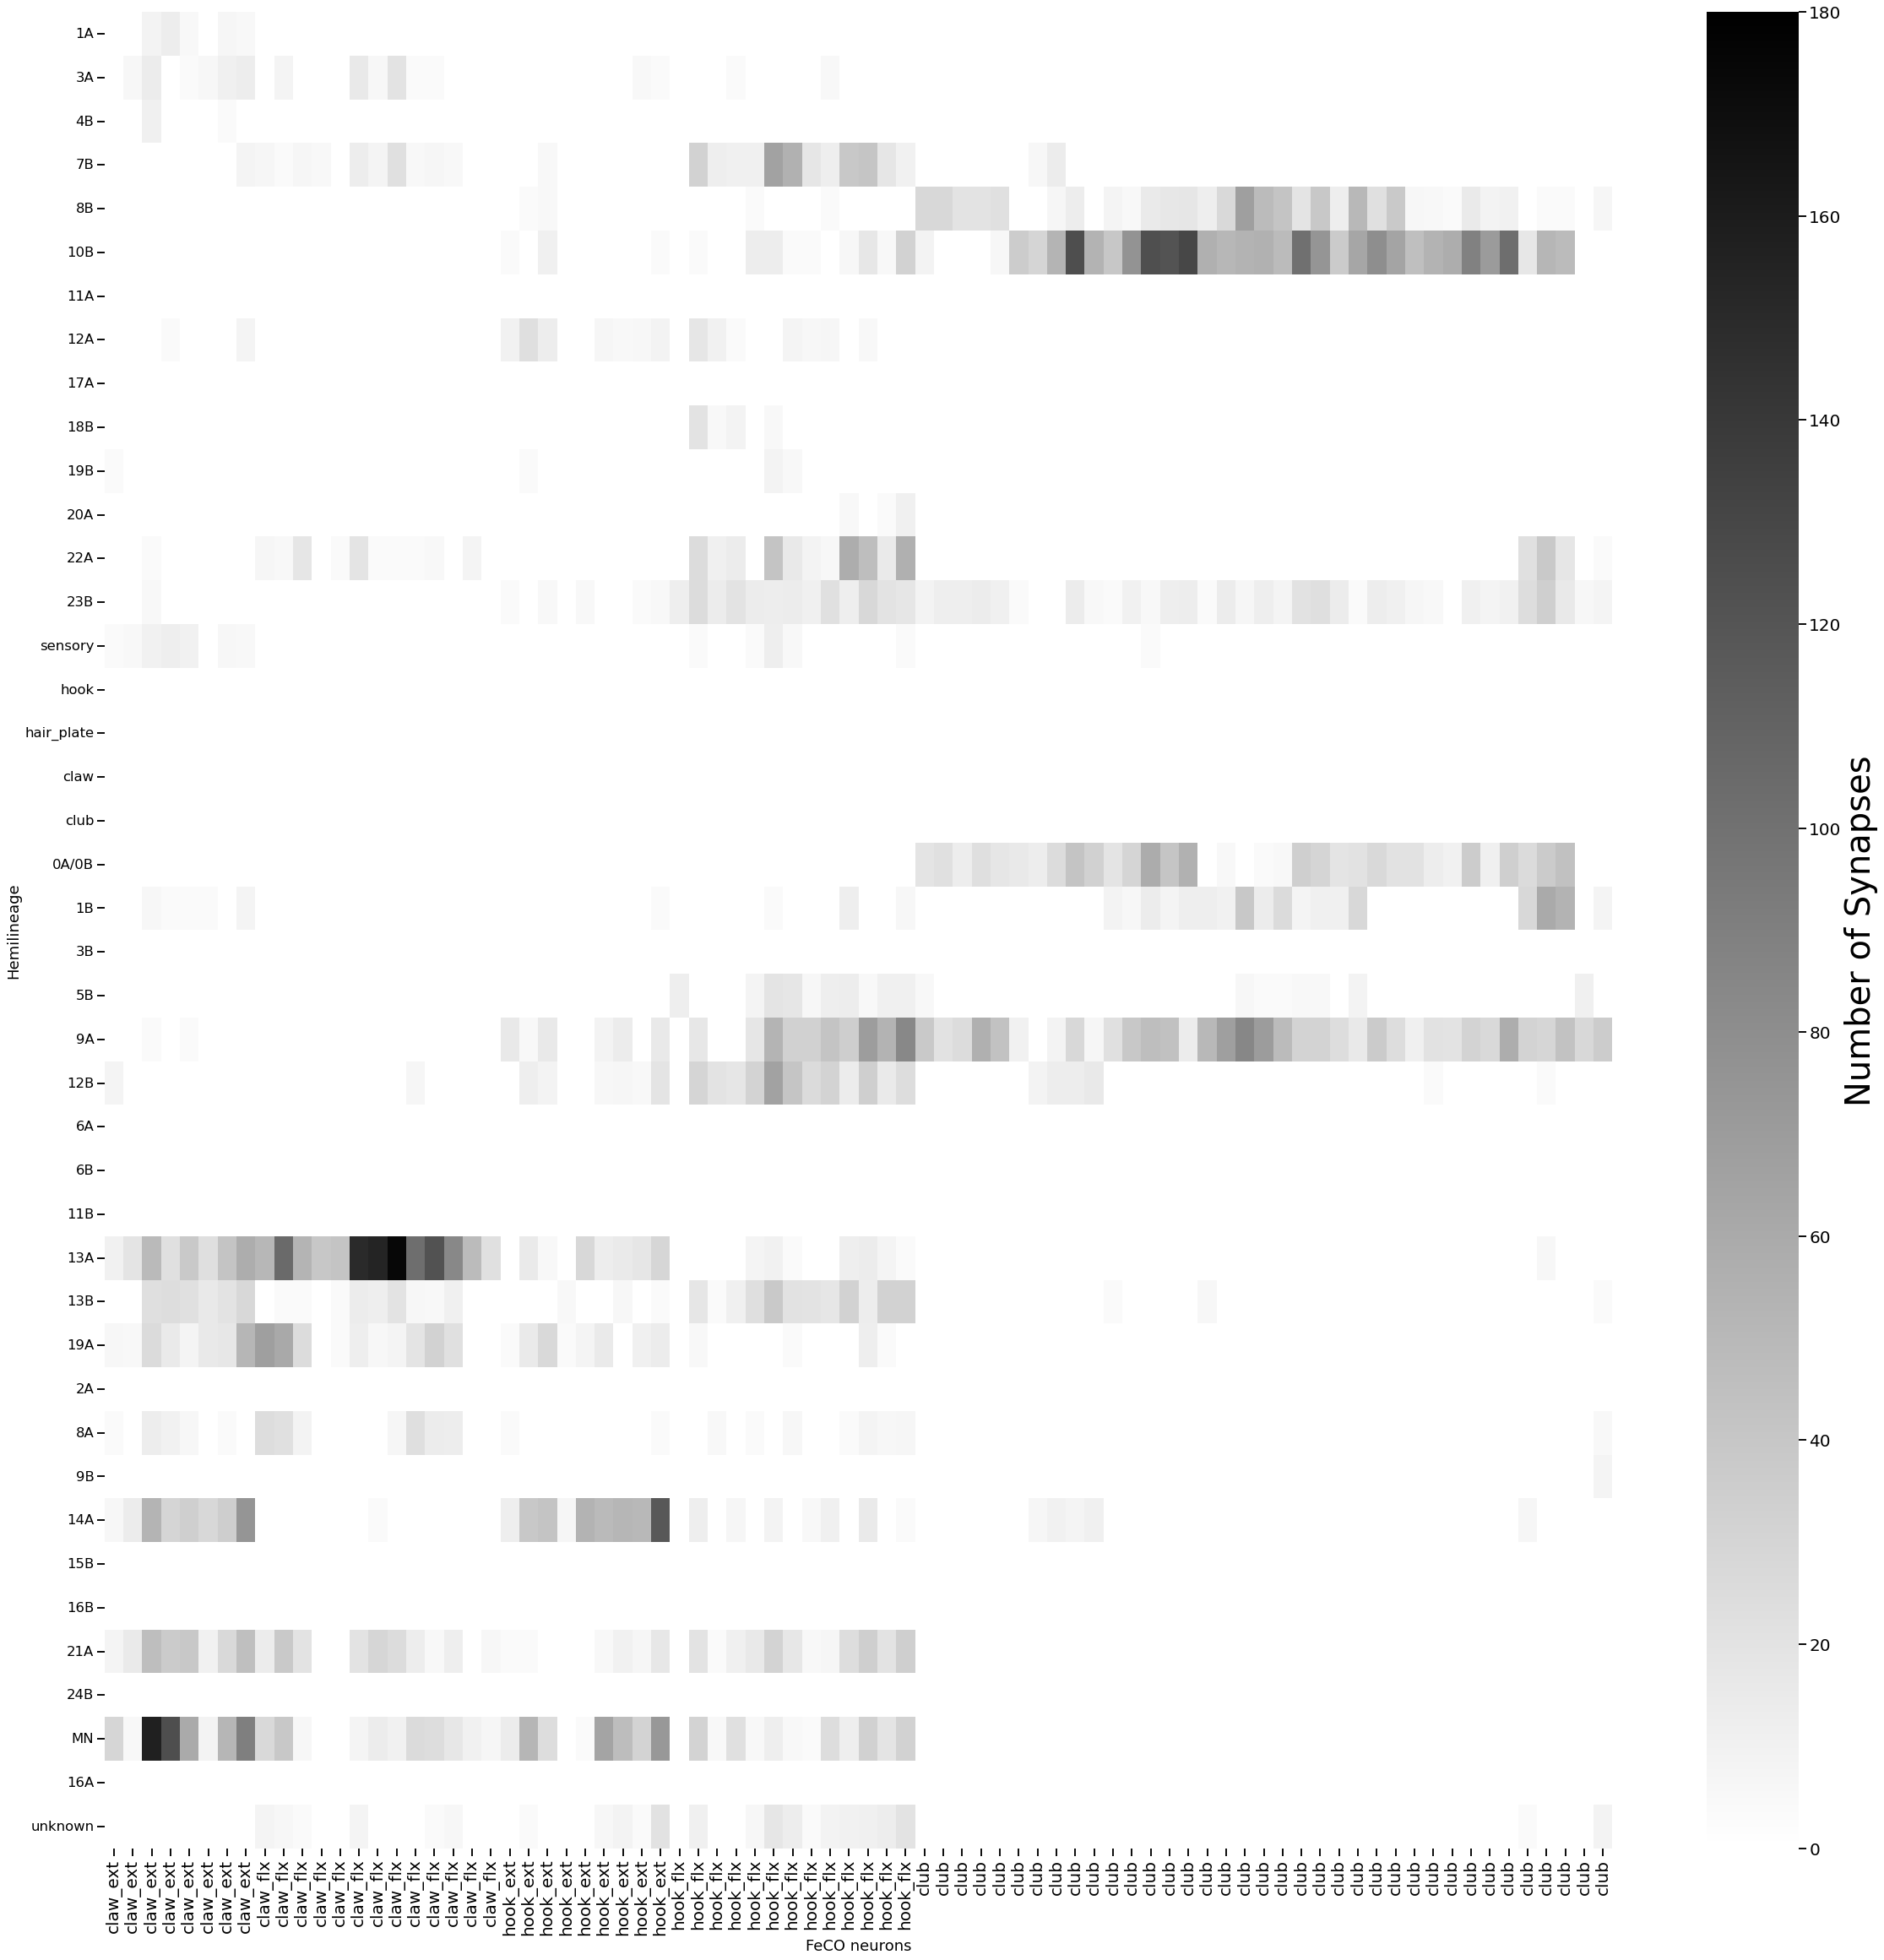

In [18]:
# plot output connectivity matrix heatmap (collapsed)

gray_map = sns.color_palette("blend:white,black", as_cmap=True)
figure_size = [40, 40]
fig = plt.figure(1, figsize = figure_size)
sns.set_context("talk")
ytick_fontsize = 10
xtick_fontsize = 20

ax = sns.heatmap(output_connex_collapsed, yticklabels = 1, cmap=gray_map, vmin=0, vmax=180)

ax.set(xlabel='FeCO neurons')
ax.set(ylabel='Hemilineage')
cbar = ax.collections[0].colorbar

cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'Number of Synapses', size=figure_size[1])
plt.xticks(fontsize = xtick_fontsize,rotation = 90)
plt.show()

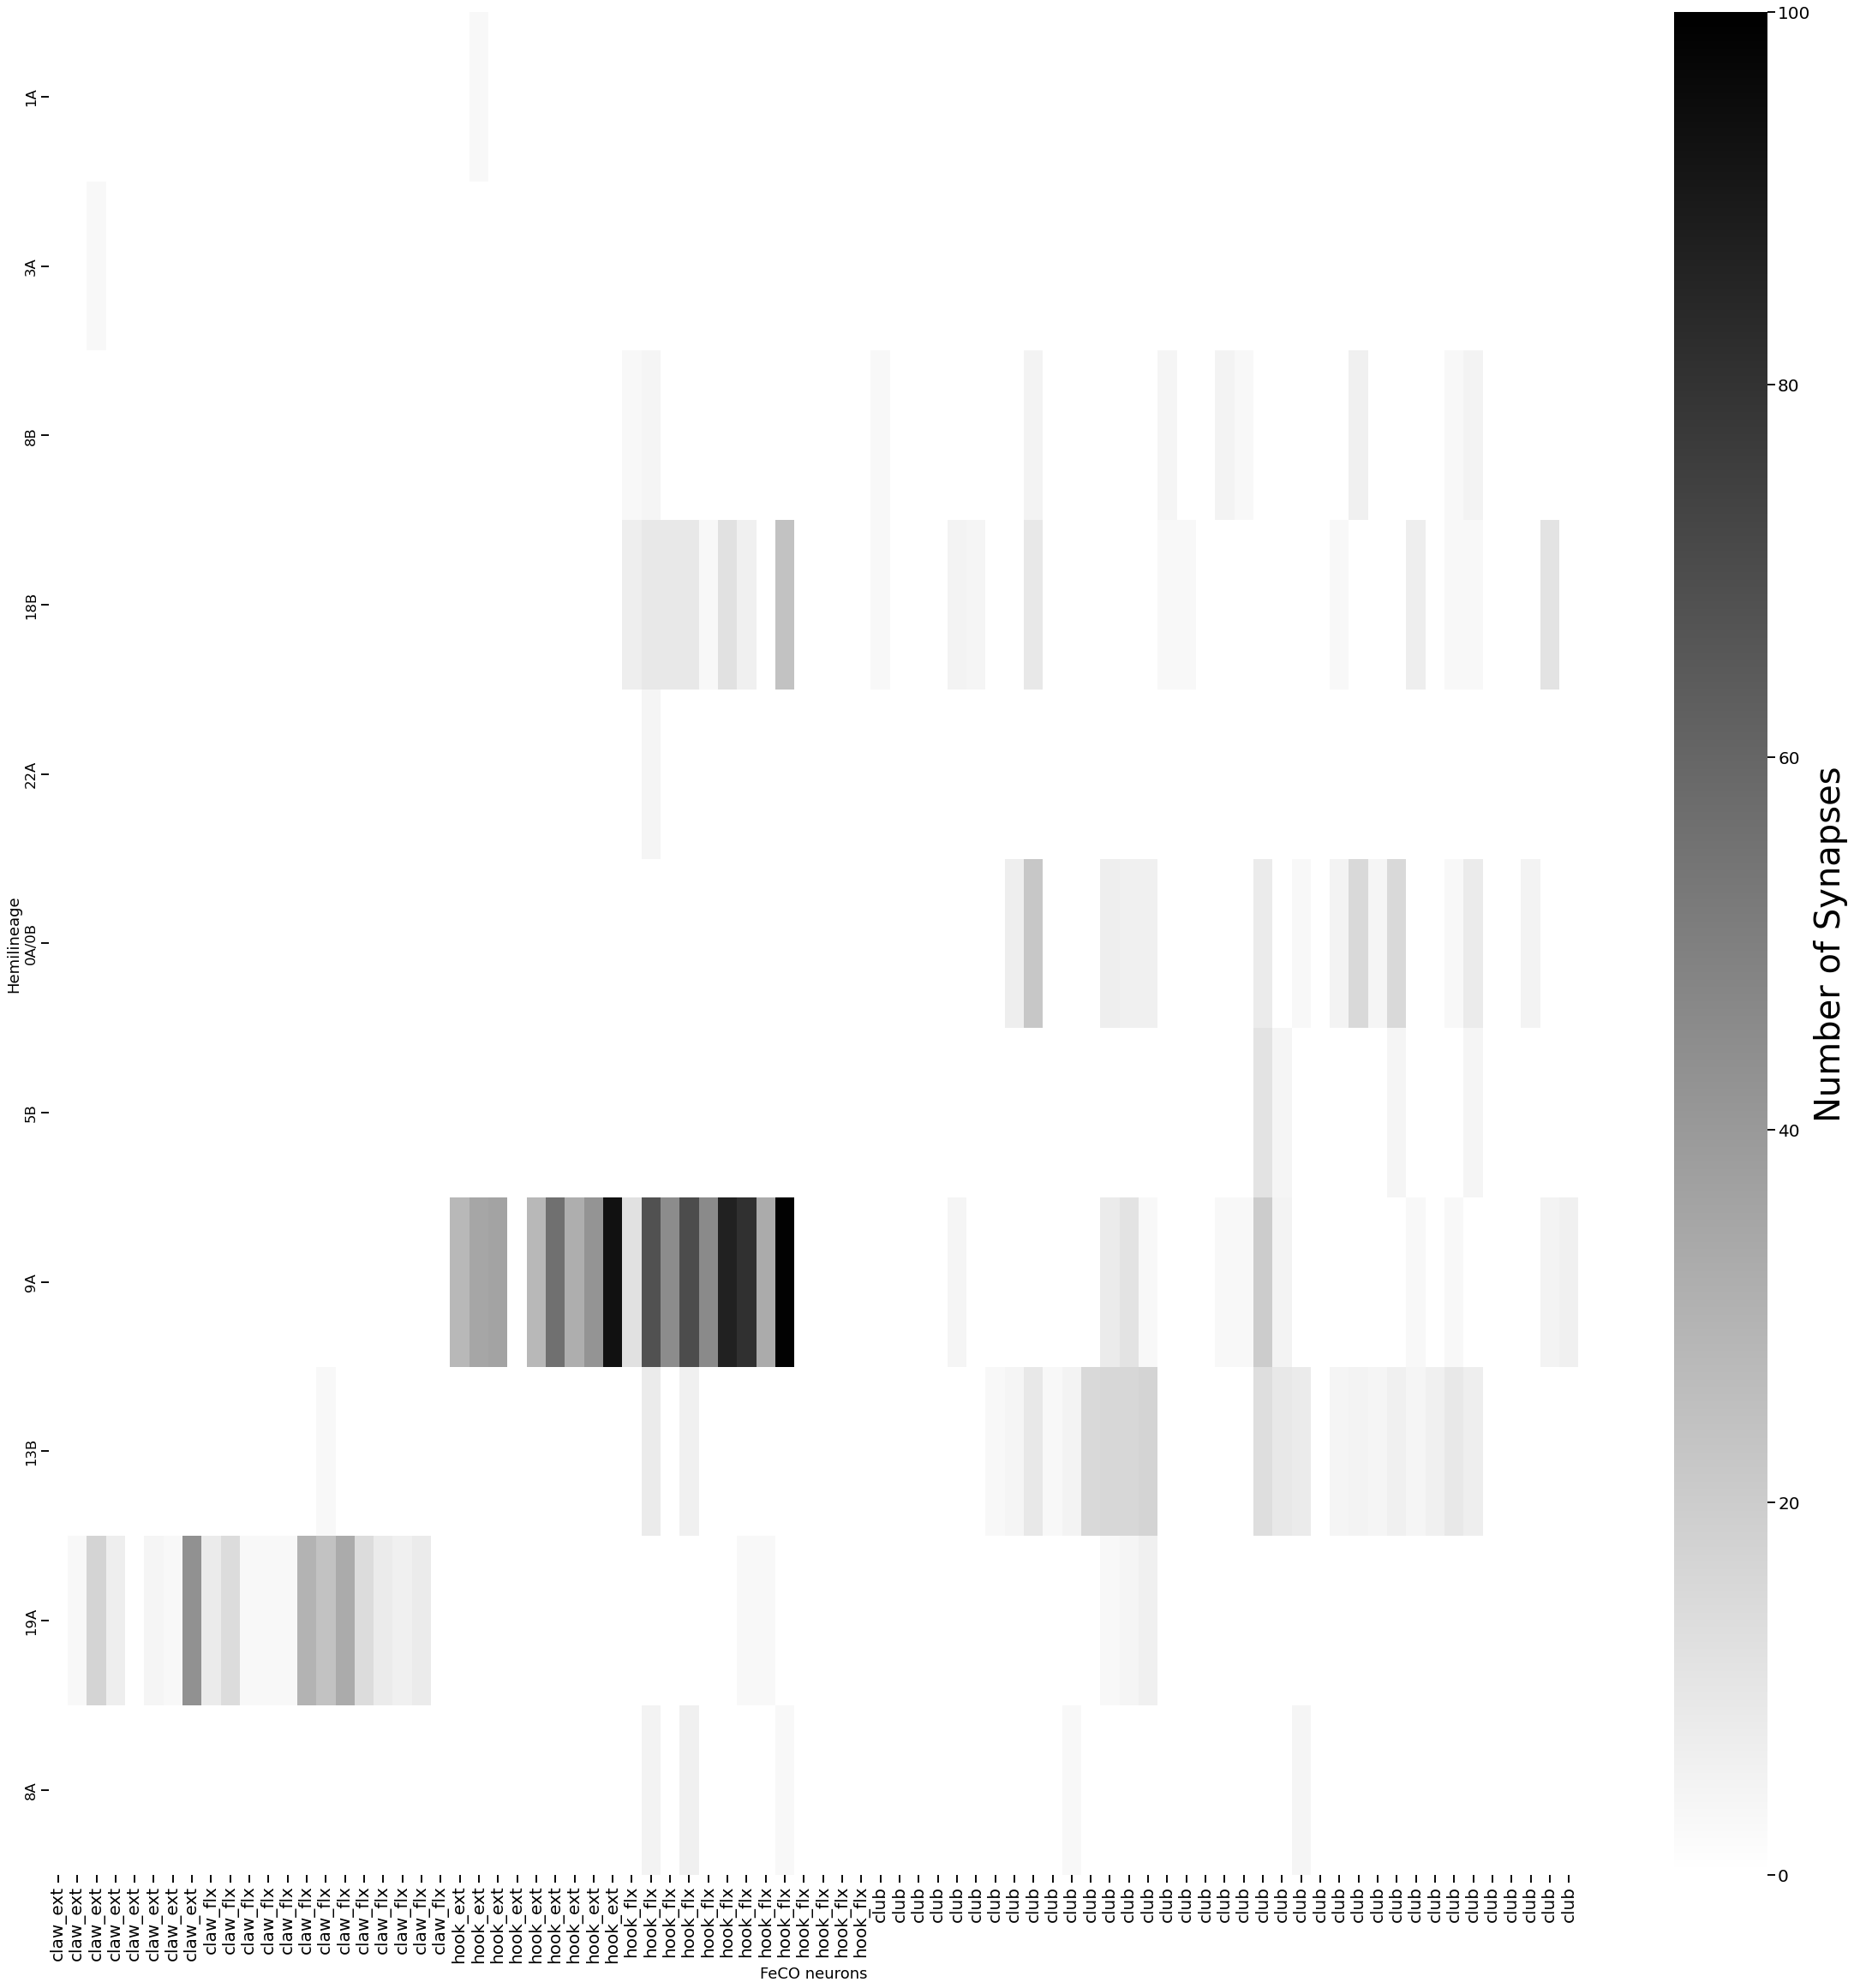

In [19]:
# plot input connectivity matrix heatmap (collapsed)

gray_map = sns.color_palette("blend:white,black", as_cmap=True)
figure_size = [40, 40]
fig = plt.figure(1, figsize = figure_size)
sns.set_context("talk")
ytick_fontsize = 10
xtick_fontsize = 20

these_HL = ['1A', '3A', '8B', '18B', '22A', '0A/0B', '5B', '9A', '13B', '19A', '8A']
mask = input_connex_collapsed.index.isin(these_HL)
active_rows = input_connex_collapsed[mask]

ax = sns.heatmap(active_rows, yticklabels = 1, cmap=gray_map, vmin=0, vmax=100)
ax.set(xlabel='FeCO neurons')
ax.set(ylabel='Hemilineage')
cbar = ax.collections[0].colorbar


cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'Number of Synapses', size=figure_size[1])
plt.xticks(fontsize = xtick_fontsize,rotation = 90)
plt.show()

In [20]:
output_connex2_collapsed = pd.DataFrame(all_output_mx_collapsed, columns = allFeCO_types_clustered)
output_connex2_collapsed = output_connex2_collapsed.div(output_connex2_collapsed.sum(axis=1), axis=0)*100
output_connex2_collapsed['HL'] = HL_order

rearranged_outputconnex2 = pd.melt(output_connex2_collapsed, id_vars=['HL'])
rearranged_outputconnex2 = rearranged_outputconnex2.groupby(["variable", "HL"])['value'].sum().reset_index(name="value")

input_connex2_collapsed = pd.DataFrame(all_input_mx_collapsed, columns = allFeCO_types_clustered)
input_connex2_collapsed = input_connex2_collapsed.div(input_connex2_collapsed.sum(axis=1), axis=0)*100
input_connex2_collapsed['HL'] = HL_order

rearranged_inputconnex2 = pd.melt(input_connex2_collapsed, id_vars=['HL'])
rearranged_inputconnex2 = rearranged_inputconnex2.groupby(["variable", "HL"])['value'].sum().reset_index(name="value")

rearranged_outputconnex3 = rearranged_outputconnex2.pivot(index='HL', columns='variable', values='value')
rearranged_inputconnex3 = rearranged_inputconnex2.pivot(index='HL', columns='variable', values='value')

NameError: name 'fig_path' is not defined

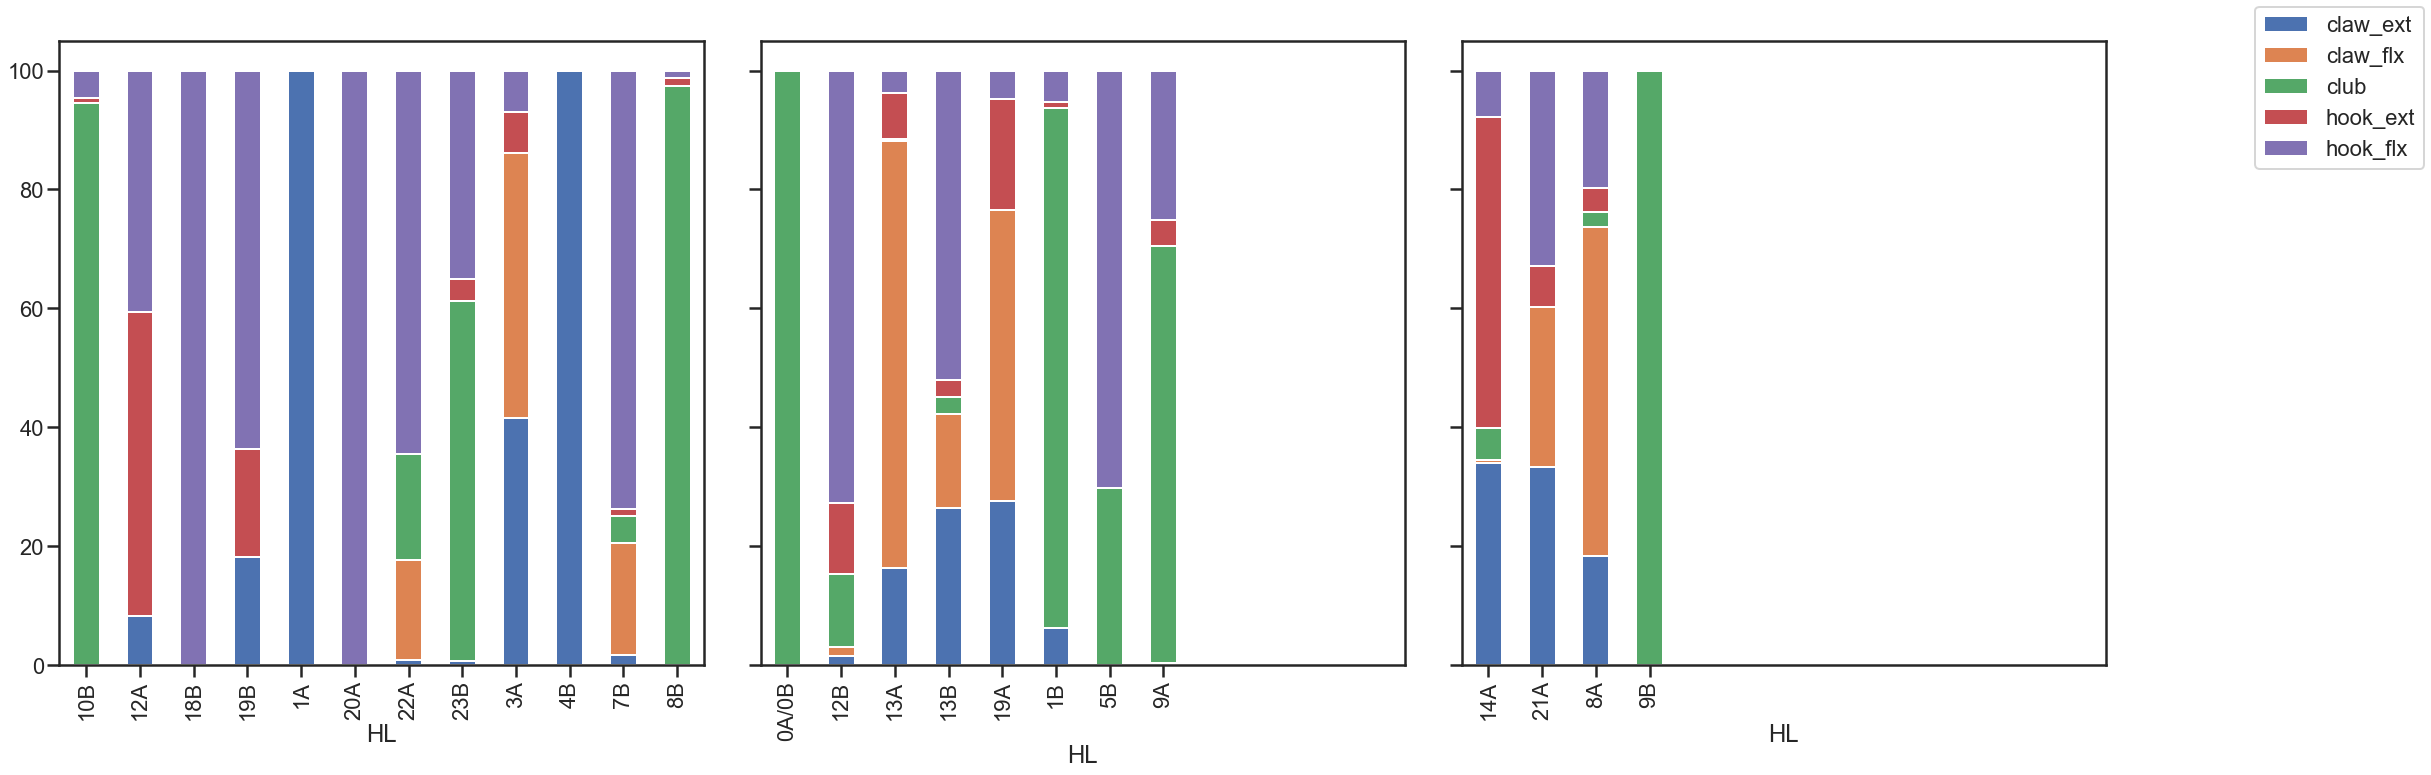

In [21]:
sns.set_theme()
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("poster")

f ,axs =plt.subplots(1,3,figsize=(30,10), sharey=True, sharex=False)
f.tight_layout()

###########################################
#subset out AcH stuff
these_HL = ['1A', '3A', '4B', '7B', '8B', '10B', '12A', '18B', '19B', 
          '20A', '22A', '23B']
mask = rearranged_outputconnex3.index.isin(these_HL)
active_rows = rearranged_outputconnex3[mask]


active_rows.plot(kind='bar', stacked=True, ax=axs[0], legend = False)
f.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

#####################################################
#subset out the GABA stuff
these_HL = ['0A/0B', '1B', '5B', '9A','12B', '13A', '13B', '19A']
mask = rearranged_outputconnex3.index.isin(these_HL)
active_rows = rearranged_outputconnex3[mask]


active_rows.plot(kind='bar', stacked=True, ax=axs[1], legend = False)
axs[1].set_xlim(-0.5,12-0.5)



######################################################
#subset out the Glu stuff
these_HL = ['8A', '9B', '14A', '21A']
mask = rearranged_outputconnex3.index.isin(these_HL)
active_rows = rearranged_outputconnex3[mask]


active_rows.plot(kind='bar', stacked=True, ax=axs[2], legend = False)
axs[2].set_xlim(-0.5,12-0.5)


(-0.5, 11.5)

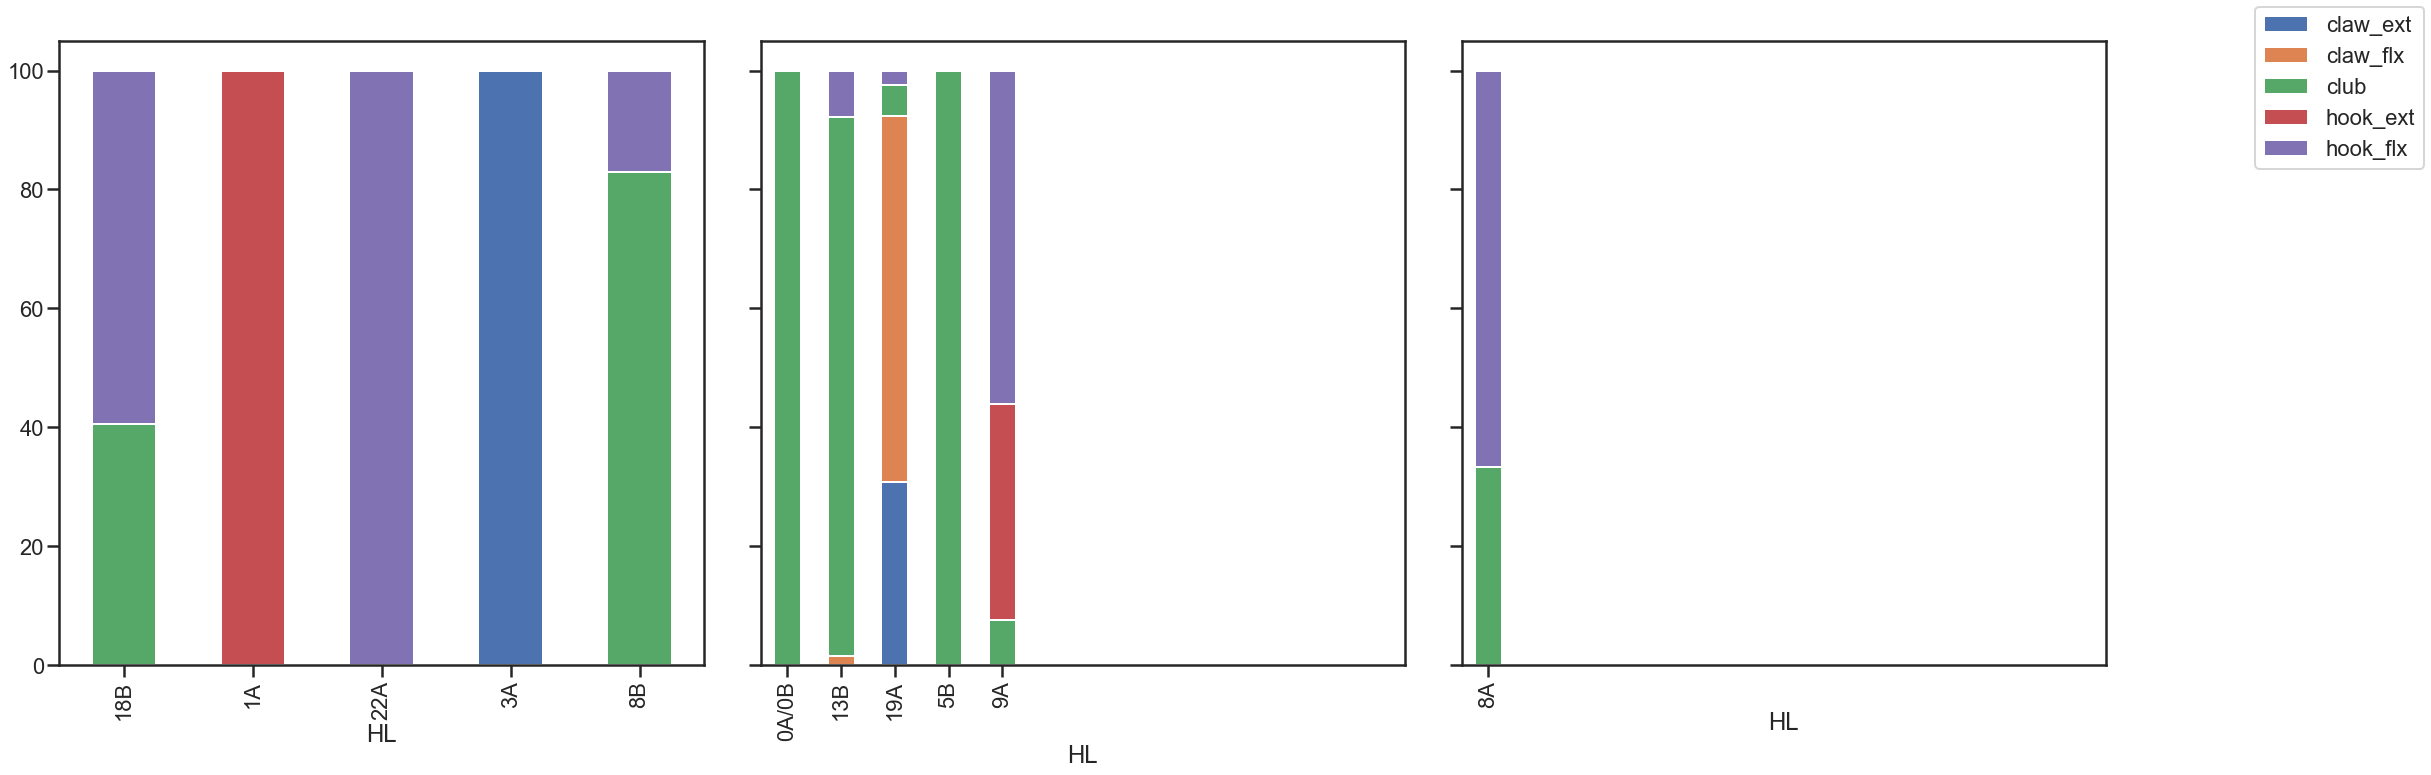

In [23]:
sns.set_theme()
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("poster")

f ,axs =plt.subplots(1,3,figsize=(30,10), sharey=True, sharex=False)
f.tight_layout()

###########################################
#subset out AcH stuff
these_HL = ['1A', '3A', '8B', '18B', '22A']
mask = rearranged_inputconnex3.index.isin(these_HL)
active_rows = rearranged_inputconnex3[mask]


active_rows.plot(kind='bar', stacked=True, ax=axs[0], legend = False)
f.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

#####################################################
#subset out the GABA stuff
these_HL = ['0A/0B', '5B', '9A', '13B', '19A']
mask = rearranged_inputconnex3.index.isin(these_HL)
active_rows = rearranged_inputconnex3[mask]


active_rows.plot(kind='bar', stacked=True, ax=axs[1], legend = False)
axs[1].set_xlim(-0.5,12-0.5)



######################################################
#subset out the Glu stuff
these_HL = ['8A']
mask = rearranged_inputconnex3.index.isin(these_HL)
active_rows = rearranged_inputconnex3[mask]


active_rows.plot(kind='bar', stacked=True, ax=axs[2], legend = False)
axs[2].set_xlim(-0.5,12-0.5)